In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [23]:
%reload_ext autoreload
%autoreload 2

In [3]:
%load_ext blackcellmagic

In [4]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import pymysql
import pymssql
import sys
import os
from functools import reduce

In [9]:
sys.path.insert(0, os.getcwd())
sys.path.insert(0, '/home/shared/utils')

In [10]:
import query as q
import extract
import preprocess as prep
import utilities as util
import model_compare as mod_com
from sklearn.metrics import confusion_matrix as cm
import EDA as eda

bank_app - loanid, entered_date, bv decisions

predicon_model - loan_id, entered_date, count of scored applicants, #positive

loans - loanid, lead_time_added, #lender approved

## In a Nutshell

### Extracting Data

In [11]:
bank_app = extract.extract_bankapp("'2020-06-09'")

In [12]:
model = extract.extract_model()

In [13]:
loan_history = extract.extract_loan_history("'2020-06-09'")

### Modifying Data

In [14]:
modified_bank_app = prep.preprocess_bankapp_db(bank_app)

In [15]:
modified_model_scores = prep.preprocess_model_db(model)

In [16]:
modified_loan_history = prep.preprocess_loan_history_db(loan_history)

In [17]:
is_BV_uncertain_approved = modified_bank_app['agent_decision'].isin(['Bank Validation Uncertain', 'Bank Validation Approved'])
modified_bank_app = modified_bank_app[is_BV_uncertain_approved]

### Analysing loanids which were not lender approved but our model approved

In [18]:
dfs = [modified_bank_app, modified_model_scores, modified_loan_history]
merged_db = reduce(lambda left, right : pd.merge(left, right, on = 'LoanId', how = 'left'), dfs)

In [19]:
merged_db['Decision'].fillna(-1, inplace = True)

In [25]:
util.get_confusion_matrix(merged_db, norm = 'index')

Decision,-1.0,0.0,1.0
LenderApproved,,,
0.0,0.234822,0.528349,0.236829
1.0,0.216929,0.528215,0.254857


(No Sale Lender               36
 No Sale 3rd Party Scrub      24
 No Sale Bank Verification     8
 No Sale Employer              2
 No Sale Misc                  2
 Approved                      1
                               1
 Name: underwriting_final_decision, dtype: int64,
 <seaborn.axisgrid.FacetGrid at 0x7fe7ce6e33d0>)

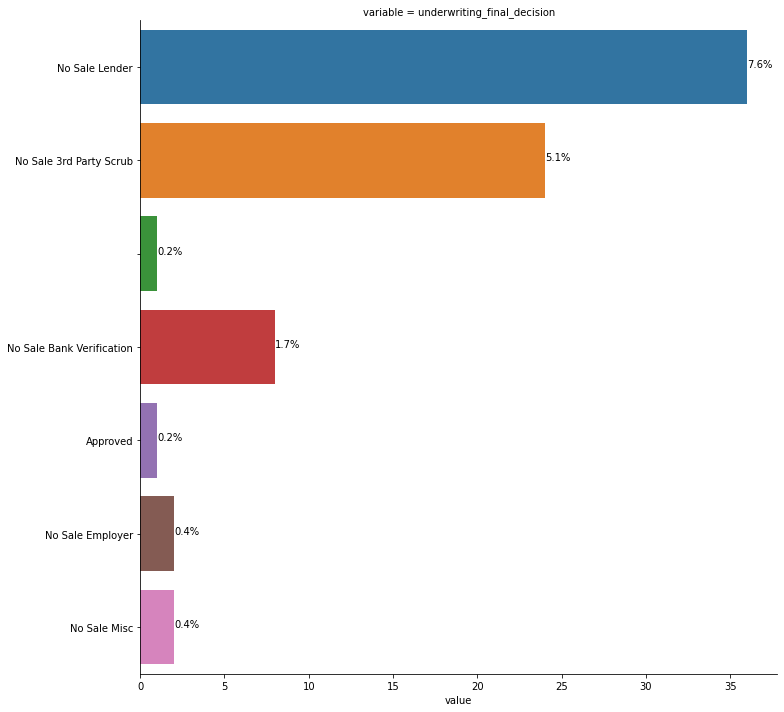

In [22]:
util.get_lender_approved_model_disapproved_reasons(merged_db)